In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from mosqlient import get_predictions
from mosqlient.models.score import Scorer

import seaborn as sns
from itertools import product
import matplotlib.dates as mdates

In [2]:
import warnings 
# Ignore all FutureWarnings
warnings.filterwarnings("ignore")

In [3]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)
    
    data_.set_index('date', inplace = True)
    
    data_ = data_[['casos']].resample('W-SUN').sum()

    data_ = data_.reset_index()

    data_ = data_.rename(columns = {'date':'dates'})
    
    return data_

In [4]:
data = pd.read_csv('data/dengue.csv.gz')

data.head()

,date,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
0,2010-01-03,2010,201001,0,4208450,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False
1,2010-01-03,2010,201001,0,4216206,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False
2,2010-01-03,2010,201001,0,4218509,Meio Oeste,42008,Meio Oeste e Serra Catarinense,4212,SC,True,True,False,False
3,2010-01-03,2010,201001,0,4216404,Extremo Sul Catarinense,42014,Sul,4210,SC,True,True,False,False
4,2010-01-03,2010,201001,0,4201307,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False


The cell below fetch the predictions from the API and compute the curve of the scores based on the data:

In [5]:
%%time 
df_score_end  = pd.DataFrame()

for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_predictions(model_id = model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            preds_id = list_of_preds[idx].id
            df_true = get_cases(data, state)
    
            score = Scorer(df_true = df_true, ids = [preds_id], confidence_level=0.9)

            year = pd.to_datetime(df.dates).dt.year.max()

            score.set_date_range(start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d'),
                                 end_date= Week(year, 40).startdate().strftime('%Y-%m-%d'))

            s1 = score.crps[0][str(preds_id)]
            s2 = score.log_score[0][str(preds_id)]
            s3 = score.interval_score[0][str(preds_id)]
            
            df_score_ = pd.DataFrame()
            df_score_['crps'] = s1
            df_score_['log_score'] = s2
            df_score_['interval_score'] = s3
            df_score_['state'] = state
            df_score_['year'] = year

            if model_id == 26:
                df_score_['model_id'] = 25
            else:
                df_score_['model_id'] = model_id

        
            df_score_end = pd.concat([df_score_end, df_score_])


CPU times: user 42.2 s, sys: 1.65 s, total: 43.8 s
Wall time: 2min 15s


Checking the shape of the data:

In [6]:
df_score_end.shape

(2600, 6)

Checking for null values:

In [7]:
df_score_end.isnull().sum()

crps              0
log_score         0
interval_score    0
state             0
year              0
model_id          0
dtype: int64

Function to plot the scores for the mandatory states: 

In [8]:
def plot_score(df_score_end, score = 'crps'):

    if score == 'crps':
        y_title = 'CRPS'
    elif score == 'log_score':
        y_title = 'Log Score'
    elif score == 'interval_score':
        y_title = 'Interval Score'
        
    fig, axs  = plt.subplots(5,2, figsize = (10, 15))
    
    ax =axs.ravel()
    
    i = 0
    for state, year in product(['AM', 'CE', 'GO', 'PR', 'MG'], [2023, 2024]):
    
        df_score_sample = df_score_end.loc[(df_score_end.state == state) & (df_score_end.year == year)].reset_index()
    
        
        sns.lineplot(data=df_score_sample, x='dates', y=score, hue='model_id', hue_order = [21, 22, 25, 27, 28, 30],
                 palette=sns.color_palette("Paired"),ax=ax[i])
    
        if year == 2023:
            ax[i].legend_.remove()
    
            ax[i].set_ylabel(y_title)
    
        if year == 2024:
            ax[i].set_ylabel('')
            ax[i].legend(title='model_id', bbox_to_anchor=(1.15, 0.525, 0.1, 0.5))
    
        ax[i].set_title(f'{state} - {year}')
    
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Format as 'Jan 22'
    
        # Rotate the date labels for better readability
        fig.autofmt_xdate(rotation=0, ha='center')
    
        i = i+1
    
    plt.tight_layout()

    plt.savefig(f'figures/curve_{score}.png', dpi = 600, bbox_inches = 'tight')
    
    plt.show()

Plot the CRPS score: 

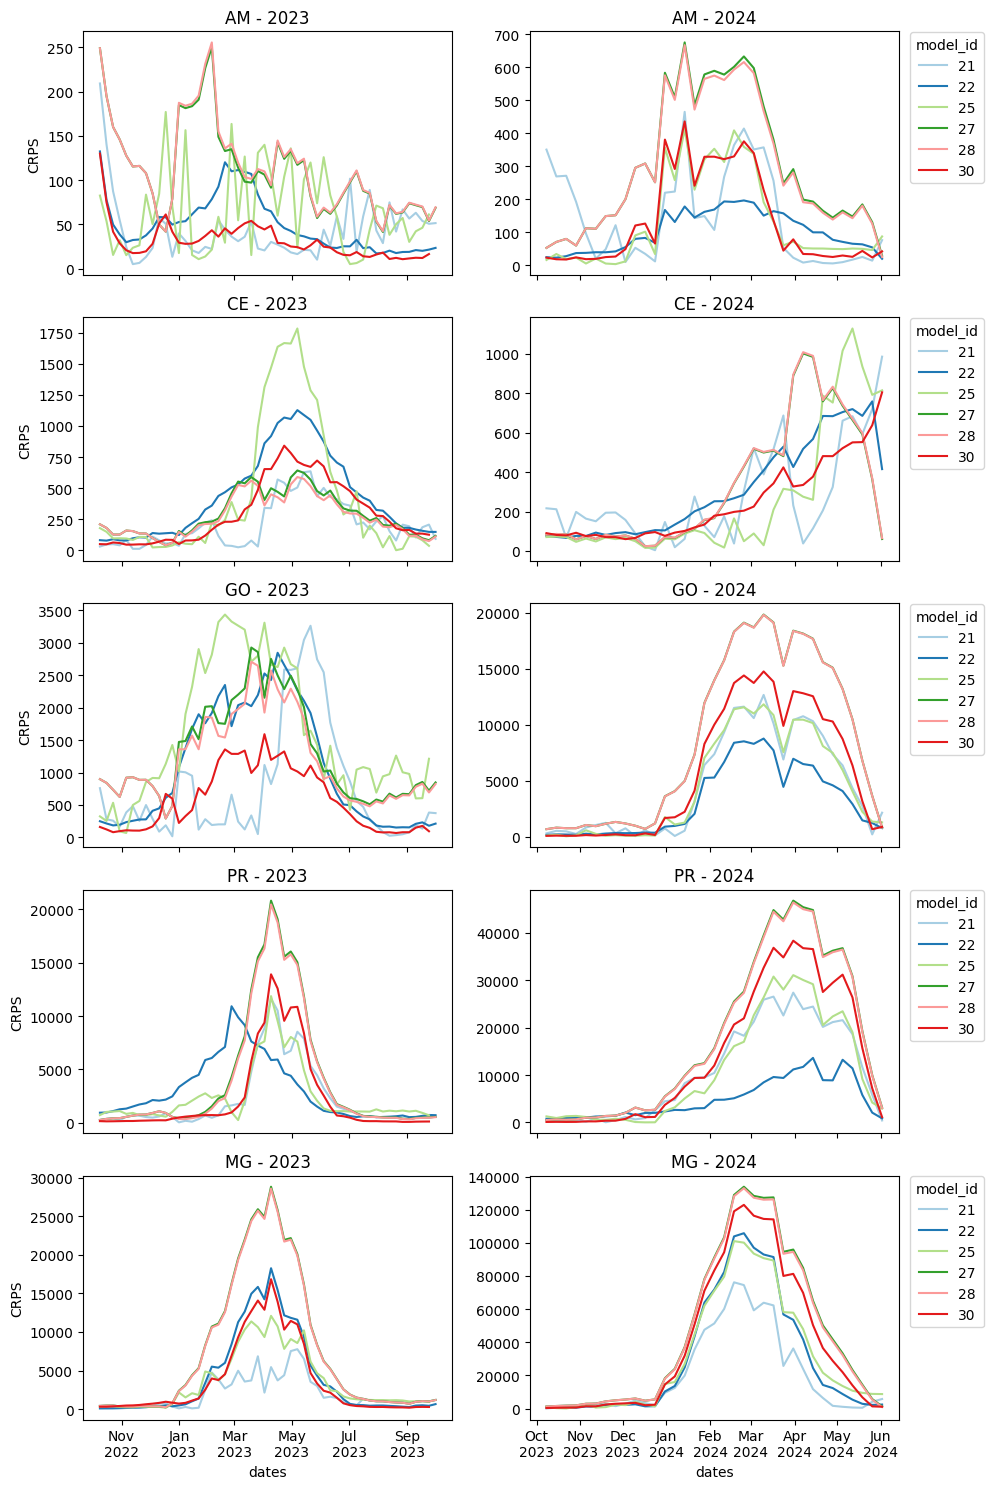

In [9]:
plot_score(df_score_end, score = 'crps')

Plot the Log Score: 

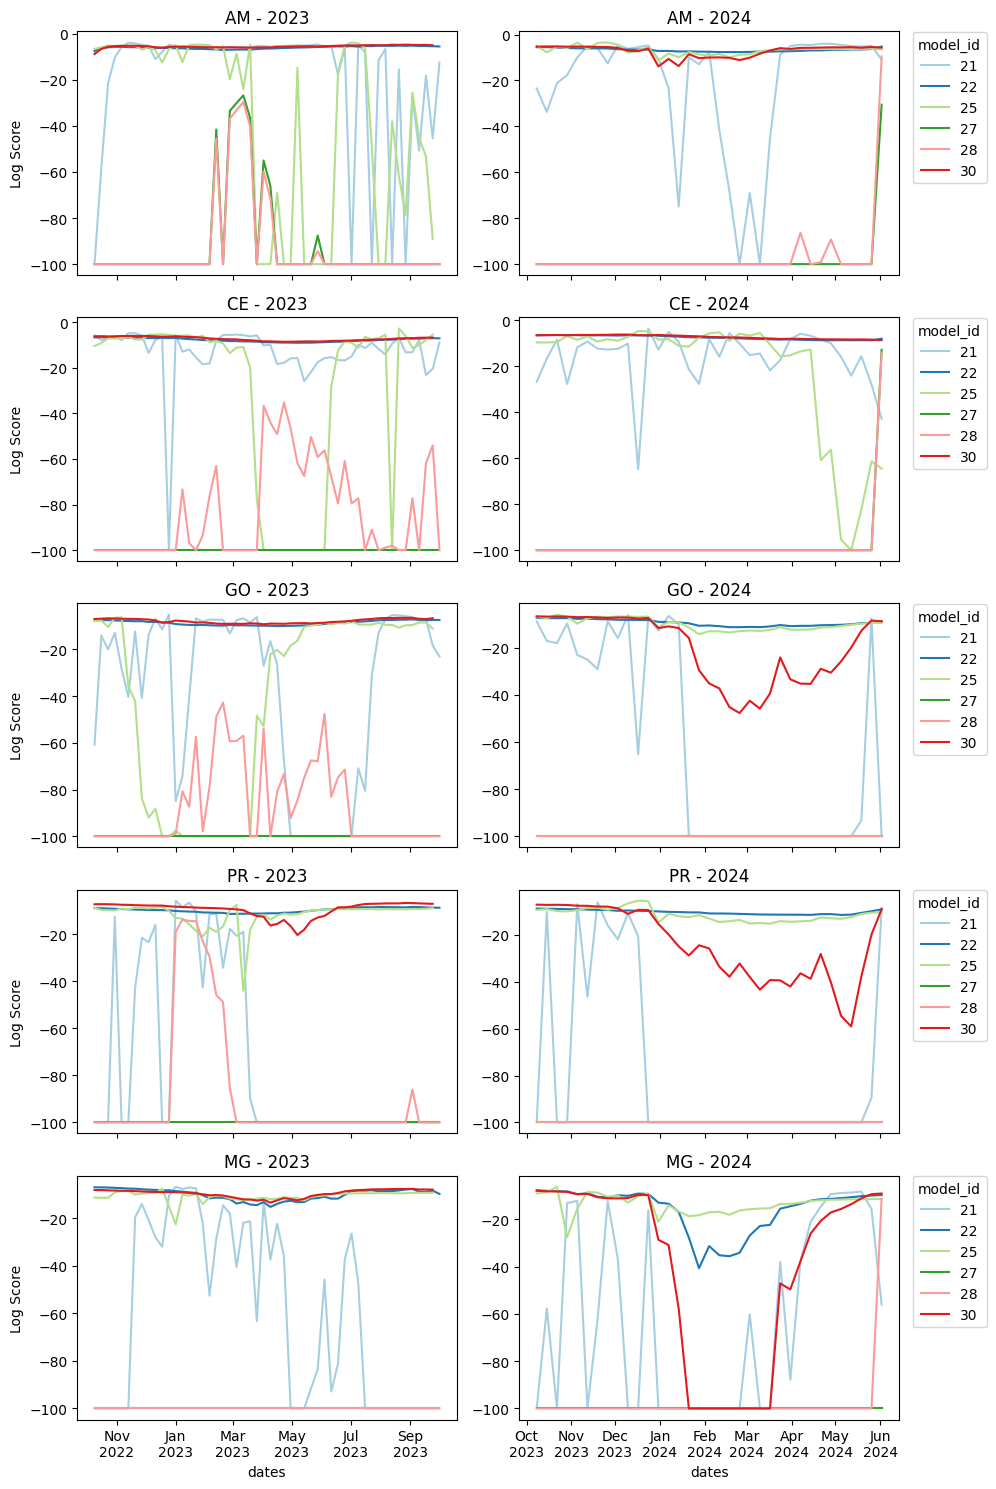

In [10]:
plot_score(df_score_end, score = 'log_score')

Plot the interval score: 

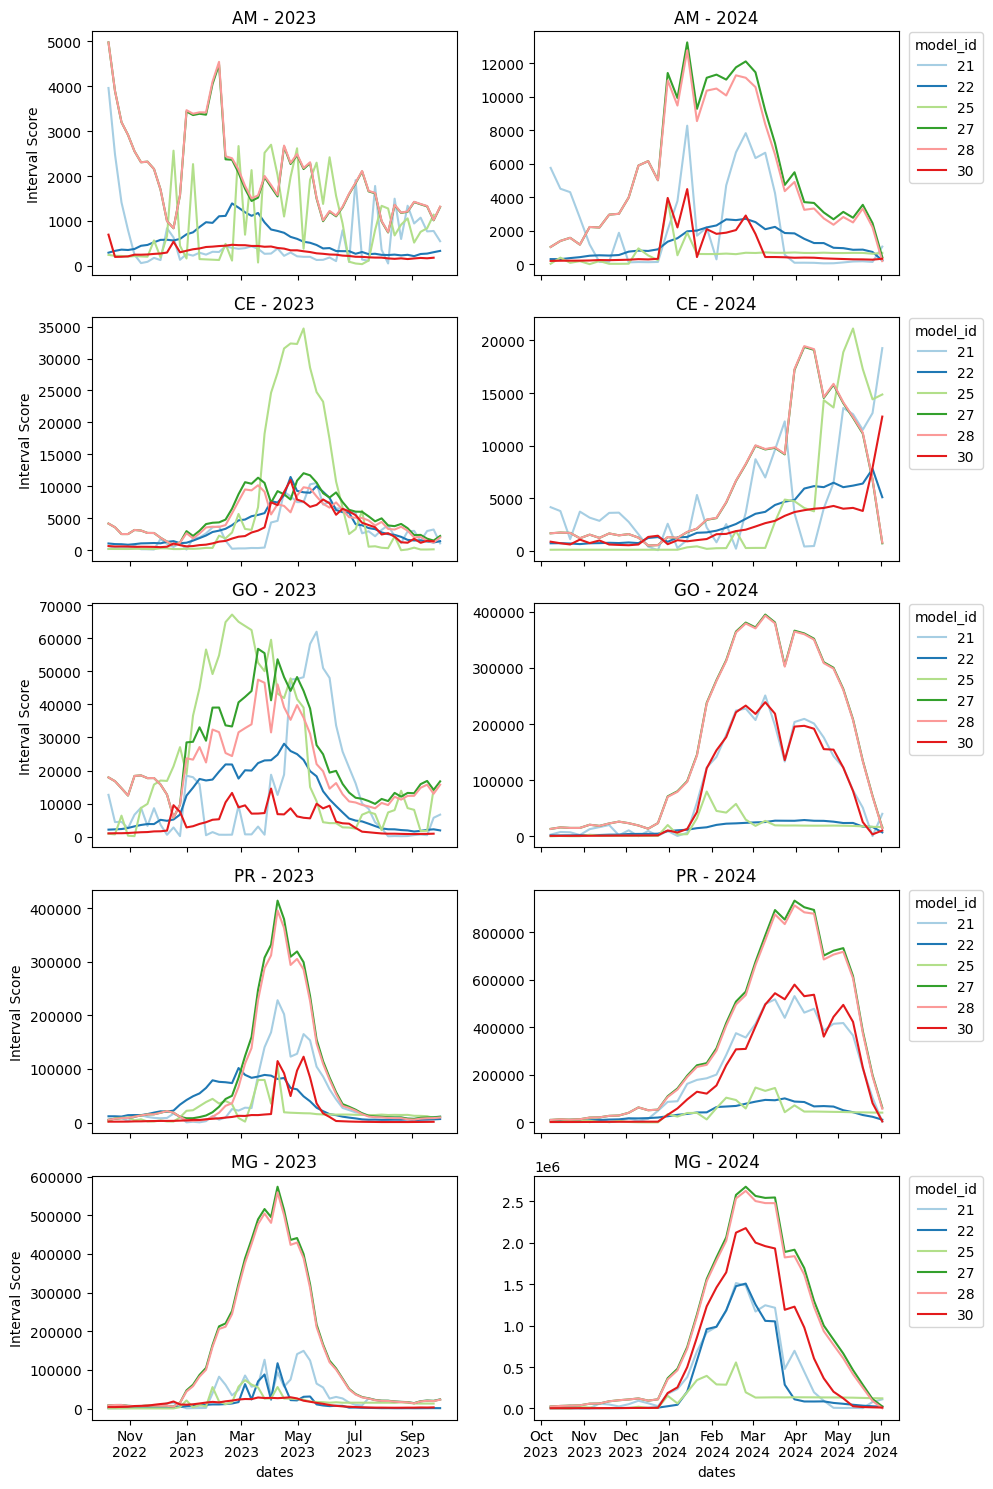

In [11]:
plot_score(df_score_end, score = 'interval_score')